In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf
from tqdm import tqdm

To simulate infinite systems, we provide the corresponding tight-binding model.

We exemplify this construction by computing the ground state of an infinite spinful chain with onsite interactions.

Because the ground state is an antiferromagnet, so we must build a two-atom cell. We name the two sublattices, $A$ and $B$. The Hamiltonian in is:
$$
H_0 = \sum_i c_{i, B}^{\dagger}c_{i, A} + c_{i, A}^{\dagger}c_{i+1, B} + h.c.
$$
We write down the spinful by simply taking $H_0(k) \otimes \mathbb{1}$.

In [2]:
hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
tb_model = {
    (0,) : hopp + hopp.T.conj(),
    (1,) : hopp,
    (-1,) : hopp.T.conj()
}

To build the tight-binding model, we need to generate a Hamiltonian on a k-point and the corresponding hopping vectors to generate a guess. We then verify the spectrum and see that the bands indeed consistent of two bands due to the Brillouin zone folding.

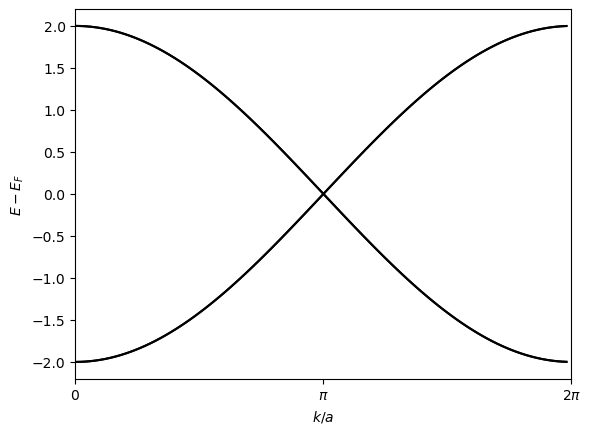

In [3]:
# Set number of k-points
nk = 100
hk = utils.model2hk(tb_model=tb_model)
# Compute Hamiltonian on the corresponding k-point grid
hamiltonians_0, ks = utils.kgrid_hamiltonian(
    nk=nk, hk=hk, dim=1,
    return_ks=True
)
# Perform diagonalization
vals, vecs = np.linalg.eigh(hamiltonians_0)
# Plot data
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

Here, in the workflow to find the ground state, we use a helper function to build the initial guess. because we don't need a dense k-point grid in the self-consistent loop, we compute the spectrum later on a denser k-point grid.

In [4]:
def compute_gap(
    hk,
    Vk,
    nk,
    nk_dense,
    filling=2
):
    # Find groundstate Hamiltonian on the same grid
    _, mf_model = hf.find_groundstate_ham(
        hk=hk,
        Vk=Vk,
        filling=filling,
        dim=1,
        nk=nk,
        cutoff=1,
        return_model=True
    )
    # Generate Hamiltonian on a denser k-point grid
    mf_k = utils.kgrid_hamiltonian(
        nk=nk_dense,
        hk=utils.model2hk(tb_model=mf_model),
        dim=1
    )
    # Diagonalize groundstate Hamiltonian
    vals, _ = np.linalg.eigh(mf_k)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, vals - E_F

Finally, we compute the eigen0alues for a set of Ualues of $U$. For this case, since the interaction is onsite only, the interaction matrix is simply
$$
H_{int} =
\left(\begin{array}{cccc}
    U & U & 0 & 0\\
    U & U & 0 & 0\\
    0 & 0 & U & U\\
    0 & 0 & U & U
\end{array}\right)~.
$$

In [5]:
def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
):
    gap = []
    vals = []
    for U in tqdm(Us):
        # onsite interactions
        int_model = {
            (0,) : U * np.kron(np.ones((2, 2)), np.eye(2))
        }
        Vk = utils.model2hk(tb_model=int_model)
        _gap, _vals = compute_gap(
            hk=hk,
            Vk=Vk,
            nk=nk,
            nk_dense=nk_dense,
        )
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

In [6]:
# Interaction strengths
Us = np.linspace(0, 20, 20, endpoint=True)
nk, nk_dense = 20, 100
gap, vals = compute_phase_diagram(Us=Us, nk=nk, nk_dense=nk_dense)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


In [7]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(
        vals=(["Us", "ks", "n"], vals),
        gap=(["Us"], gap)
    ),
    coords=dict(Us=Us, ks=np.linspace(0, 2 * np.pi, nk_dense), n=np.arange(vals.shape[-1])),
)

We observe that as the interaction strength increases, a gap opens due to the antiferromagnetic ordering.

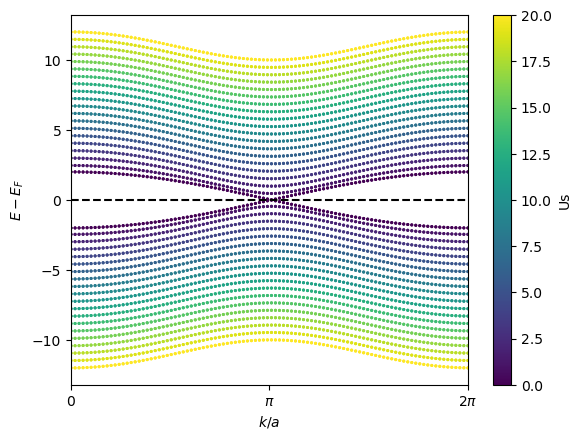

In [8]:
ds.vals.plot.scatter(x='ks', hue='Us', ec=None, s=5)
plt.axhline(0, ls='--', c='k')
plt.xticks([0, np.pi, 2 * np.pi], ['$0$', '$\pi$', '$2\pi$'])
plt.xlim(0, 2 * np.pi)
plt.ylabel('$E - E_F$')
plt.xlabel('$k / a$')
plt.show()

The Hartree-Fock dispersion should follow (see [these notes](https://www.cond-mat.de/events/correl11/manuscript/Lechermann.pdf))
$$
\epsilon_{HF}^{\sigma}(\mathbf{k}) = \epsilon(\mathbf{k}) + U \left(\frac{n}{2} + \sigma m\right)
$$
where $m=(\langle n_{i\uparrow} \rangle - \langle n_{i\downarrow} \rangle) / 2$ is the magnetization per atom and $n = \sum_i \langle n_i \rangle$ is the total number of atoms per cell. Thus, for the antiferromagnetic groundstate, $m=1/2$ and $n=2$. The gap thus should be $\Delta=U$. And we can confirm it indeed follows the expected trend.

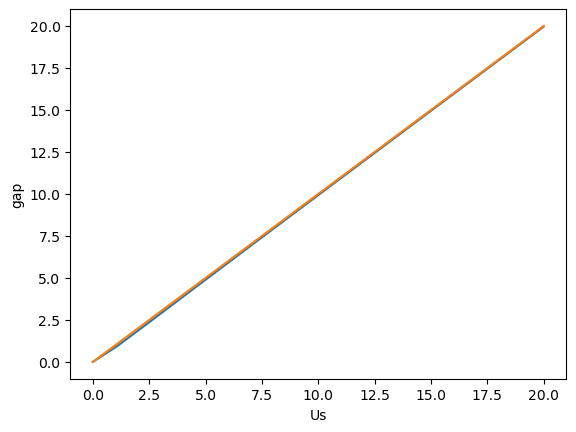

In [9]:
ds.gap.plot()
plt.plot(ds.Us, ds.Us)
plt.show()

We can also fit 

In [10]:
ds.gap.polyfit(dim='Us', deg=1).polyfit_coefficients[0].data

array(1.00352529)

In [11]:
ds.to_netcdf('./data/1d_hubbard_example.nc')